## NLP Final Presentation: Code Pipeline

Ruocheng Shan

Xuzheng Lu

Kai Wang

Ruikai Zhou

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from read_data import load_file_conll, load_file_science
from CRF.crf_train_conll2000 import sent2features, sent2labels, word2features
import joblib
from sklearn_crfsuite import metrics
import sklearn_crfsuite

from BERT.bert_conll2000 import get_bert_test_conll
from BERT.bert_scienceEXAM import get_bert_test_sci

## 1. Data

In [ ]:
def get_tag_number(sentence_list):
    result = {}
    for i in sentence_list:
        for j in i:
            if j[2] not in result:
                result[j[2]] = 1
            else:
                result[j[2]] += 1
    return result

### 1.1 CoNll-2000

In [ ]:
sentence_conll_tr, words_conll_test_tr, pos_tags_conll_tr, ner_tags_conll_tr = load_file_conll("train.txt")
sentence_conll_test, words_conll_test, pos_tags_conll_test, ner_tags_conll_test = load_file_conll("test.txt")

In [ ]:
labels_conll = ner_tags_conll_tr.remove("O")

In [ ]:
sentence_conll_tr[0]

[('Confidence', 'NN', 'B-NP'),
 ('in', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('pound', 'NN', 'I-NP'),
 ('is', 'VBZ', 'B-VP'),
 ('widely', 'RB', 'I-VP'),
 ('expected', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('take', 'VB', 'I-VP'),
 ('another', 'DT', 'B-NP'),
 ('sharp', 'JJ', 'I-NP'),
 ('dive', 'NN', 'I-NP'),
 ('if', 'IN', 'B-SBAR'),
 ('trade', 'NN', 'B-NP'),
 ('figures', 'NNS', 'I-NP'),
 ('for', 'IN', 'B-PP'),
 ('September', 'NNP', 'B-NP'),
 (',', ',', 'O'),
 ('due', 'JJ', 'B-ADJP'),
 ('for', 'IN', 'B-PP'),
 ('release', 'NN', 'B-NP'),
 ('tomorrow', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('fail', 'VB', 'B-VP'),
 ('to', 'TO', 'I-VP'),
 ('show', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('substantial', 'JJ', 'I-NP'),
 ('improvement', 'NN', 'I-NP'),
 ('from', 'IN', 'B-PP'),
 ('July', 'NNP', 'B-NP'),
 ('and', 'CC', 'I-NP'),
 ('August', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('near-record', 'JJ', 'I-NP'),
 ('deficits', 'NNS', 'I-NP'),
 ('.', '.', 'O')]

#### Token Distribution

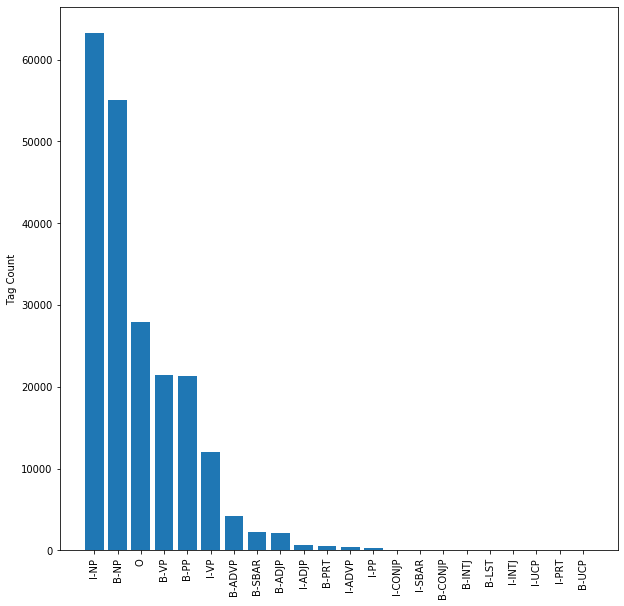

In [ ]:
token_dis_conll = get_tag_number(sentence_conll_tr)
token_dis_conll = dict(sorted(token_dis_conll.items(), key=lambda item: item[1], reverse=True))
plt.bar(range(len(token_dis_conll)), list(token_dis_conll.values()), align='center')
plt.xticks(range(len(token_dis_conll)), list(token_dis_conll.keys()), rotation=90)
plt.ylabel('Tag Count')
plt.rcParams["figure.figsize"]=10,10
plt.show()

#### Sentence Length Distribution

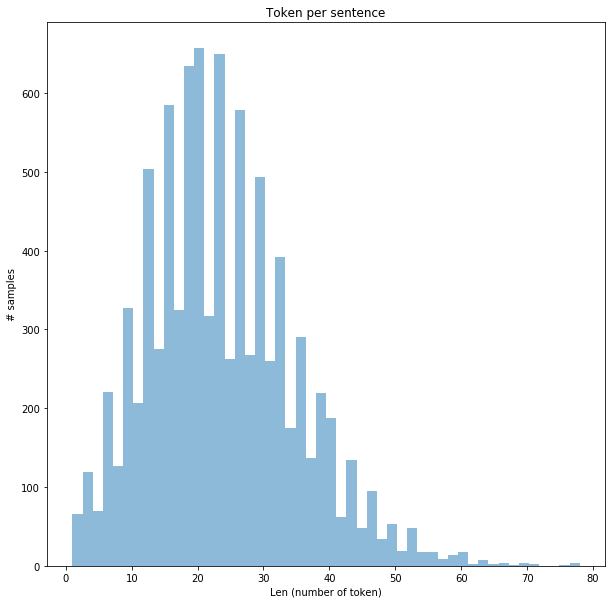

In [ ]:
plt.hist([len(s) for s in sentence_conll_tr], bins=50, alpha=0.5)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

### 1.2 ScienceExam

In [ ]:
sentence_sci_tr, words_sci_test_tr, pos_tags_sci_tr, ner_tags_sci_tr = load_file_science("train_spacy.txt")
sentence_sci_test, words_sci_test, pos_tags_sci_test, ner_tags_sci_test = load_file_science("test_spacy.txt")
sentence_sci_val, words_sci_val, pos_tags_sci_val, ner_tags_sci_val = load_file_science("valid_spacy.txt")

In [ ]:
labels_sci = ner_tags_sci_tr.remove("O")

In [ ]:
sentence_sci_tr[0]

[('Which', 'ADJ', 'B-LevelOfInclusion'),
 ('most', 'ADV', 'B-AmountComparison'),
 ('accurately', 'ADV', 'B-ProbabilityAndCertainty'),
 ('describes', 'VERB', 'B-Represent'),
 ('a', 'DET', 'O'),
 ('circle', 'NOUN', 'B-Representation'),
 ('(', 'PUNCT', 'I-Representation'),
 ('pie', 'NOUN', 'I-Representation'),
 (')', 'PUNCT', 'I-Representation'),
 ('graph', 'NOUN', 'I-Representation'),
 ('?', 'PUNCT', 'O')]

#### Token Distribution

In [ ]:
token_dis_sci = get_tag_number(sentence_sci_tr)
token_dis_sci = dict(sorted(token_dis_sci.items(), key=lambda item: item[1], reverse=True))

In [ ]:
first15pairs_dt = {k: token_dis_sci[k] for k in list(token_dis_sci)[:16]}
del first15pairs_dt["O"]

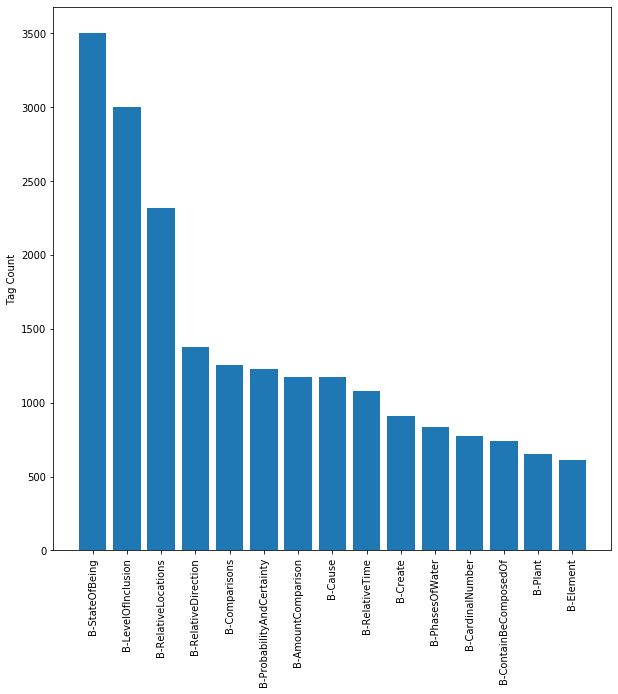

In [ ]:
plt.bar(range(len(first15pairs_dt)), list(first15pairs_dt.values()), align='center')
plt.xticks(range(len(first15pairs_dt)), list(first15pairs_dt.keys()), rotation=90)
plt.ylabel('Tag Count')
plt.show()

#### Sentence Length Distribution

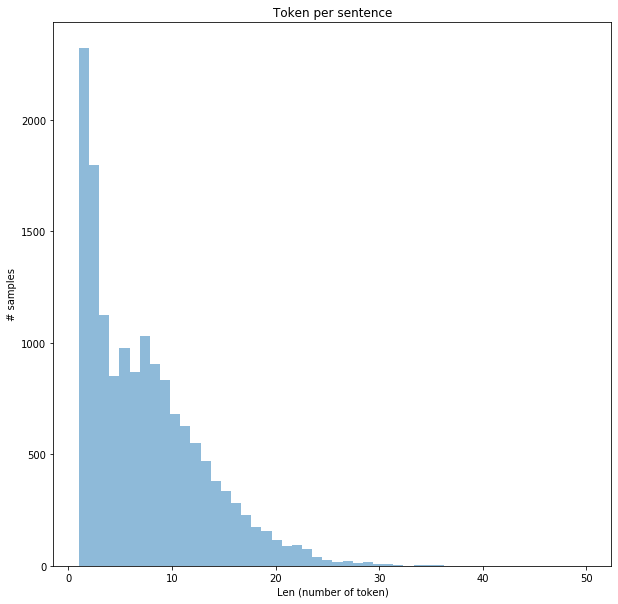

In [ ]:
plt.hist([len(s) for s in sentence_sci_tr], bins=50, alpha=0.5)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

## 2. Models

### 1.HMM - Base line

The code was developped for base line accuracy

To run the code for both data sets:
```
python hmm_midterm_demo/hmm_tagger_conll2000.py
python hmm_midterm_demo/hmm_tagger_science_exam_cer.py
```

for conll2000

<img src="hmm_midterm_demo\hmm_conll2000_logs.png">

for scienceEXAM

<img src="hmm_midterm_demo\hmm_scienceEXAM_logs.png">


### 2.CRF

In [ ]:
# prepare test set

X_test_1 = [sent2features(s) for s in sentence_conll_test]
y_test_1 = [sent2labels(s) for s in sentence_conll_test]

X_test_2 = [sent2features(s) for s in sentence_sci_test]
y_test_2 = [sent2labels(s) for s in sentence_sci_test]

In [ ]:
crf_conll = joblib.load("CRF/crf_conll2000.joblib")
crf_science = joblib.load("CRF/crf_scienceEXAM.joblib")

In [ ]:
# predict
crf_conll.predict(X_test_1[0:1])

[['B-NP',
  'I-NP',
  'I-NP',
  'B-NP',
  'I-NP',
  'I-NP',
  'B-VP',
  'B-NP',
  'B-VP',
  'B-NP',
  'I-NP',
  'I-NP',
  'B-VP',
  'B-NP',
  'I-NP',
  'B-PP',
  'B-NP',
  'I-NP',
  'B-VP',
  'I-VP',
  'B-NP',
  'I-NP',
  'B-PP',
  'B-NP',
  'B-NP',
  'I-NP',
  'I-NP',
  'O']]

#### Results-CRF

In [ ]:
# for conll2000
pred_conll = crf_conll.predict(X_test_1)
print(metrics.flat_classification_report(
        y_test_1, pred_conll, labels=labels_conll, digits=3
    ))
print("Ave Accuray:", metrics.flat_accuracy_score(y_test_1, pred_conll))
print("Ave Precision:", metrics.flat_precision_score(y_test_1, pred_conll, average='weighted', labels=labels_conll))
print("Ave Recall:", metrics.flat_recall_score(y_test_1, pred_conll, average='weighted', labels=labels_conll))
print("Ave F1-score:", metrics.flat_f1_score(y_test_1, pred_conll, average='weighted', labels=labels_conll))

              precision    recall  f1-score   support

      B-ADJP      0.794     0.758     0.776       438
      B-ADVP      0.848     0.804     0.825       866
     B-CONJP      0.455     0.556     0.500         9
      B-INTJ      1.000     1.000     1.000         2
       B-LST      0.000     0.000     0.000         5
        B-NP      0.965     0.965     0.965     12422
        B-PP      0.964     0.976     0.970      4811
       B-PRT      0.757     0.821     0.787       106
      B-SBAR      0.865     0.824     0.844       535
        B-VP      0.959     0.957     0.958      4658
      I-ADJP      0.800     0.695     0.744       167
      I-ADVP      0.643     0.607     0.624        89
     I-CONJP      0.625     0.769     0.690        13
       I-LST      0.000     0.000     0.000         2
        I-NP      0.963     0.963     0.963     14376
        I-PP      0.717     0.688     0.702        48
      I-SBAR      0.176     0.750     0.286         4
        I-VP      0.946    

In [ ]:
# for scienceEAAM
pred_sci = crf_science.predict(X_test_2)
print("Ave Accuray:", metrics.flat_accuracy_score(y_test_2, pred_sci))
print("Ave Precision:", metrics.flat_precision_score(y_test_2, pred_sci, average='weighted', labels=labels_sci))
print("Ave Recall:", metrics.flat_recall_score(y_test_2, pred_sci, average='weighted', labels=labels_sci))
print("Ave F1-score:", metrics.flat_f1_score(y_test_2, pred_sci, average='weighted', labels=labels_sci))

Ave Accuray: 0.8425619717911755
Ave Precision: 0.8397306778799688
Ave Recall: 0.8425619717911755
Ave F1-score: 0.8361435928375092


#### Demo to Train CRF

In [ ]:
X_train_1 = [sent2features(s) for s in sentence_conll_tr]
y_train_1 = [sent2labels(s) for s in sentence_conll_tr]

In [ ]:
crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True
    )
crf.fit(X_train_1, y_train_1)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

### 3. LSTM+CRF

To train the Neural Network and get results:

```
python LSTM_CRF\lstm_crf_tagger_conll2000.py
python LSTM_CRF\lstm_crf_tagger_science_exam_cer.py
```

The overall training time for scienceEXAM dataset is about 8 hours, we will skip for demo

#### for conll 2000
training process over loss

<img src="LSTM_CRF\conll2000_mask_loss.png">

training process over accuracy

<img src="LSTM_CRF\conll2000_mask_accuracy.png">

#### for science Exam
training process over loss

<img src="LSTM_CRF\science_exam_cer_mask_40_loss.png">

training process over accuracy

<img src="LSTM_CRF\science_exam_cer_mask_40_accuracy.png">

#### Results
**conll**

<img src="LSTM_CRF\conll_log.png">

**scienceEXAM**

<img src="LSTM_CRF\sci_log1.png">
<img src="LSTM_CRF\sci_log2.png">

#### 4. BERT

To train the model
```
python /BERT/bert_conll2000.py
python /BERT/bert_scienceEXAM.py
```

In [22]:
test_bert_conll2000 = get_bert_test_conll()
test_bert_conll2000[0:10]

,sentence_id,words,labels
0,0,Confidence,B-NP
1,0,in,B-PP
2,0,the,B-NP
3,0,pound,I-NP
4,0,is,B-VP
5,0,widely,I-VP
6,0,expected,I-VP
7,0,to,I-VP
8,0,take,I-VP
9,0,another,B-NP


In [21]:
test_bert_sci = get_bert_test_sci()
test_bert_sci[0:10]

,sentence_id,words,labels
0,0,Which,B-LevelOfInclusion
1,0,instrument,B-ScientificTools
2,0,measures,B-Examine
3,0,atmospheric,B-Pressure
4,0,pressure,I-Pressure
5,0,?,O
6,1,barometer,B-PressureMeasuringTool
7,2,hygrometer,B-ScientificTools
8,3,thermometer,B-TemperatureMeasuringTools
9,4,magnetometer,B-MagneticDevice


In [6]:
bert_conll = joblib.load("conll2000_bert.joblib")
bert_sci = joblib.load("ScienceExam_bert.joblib")

In [60]:
conll_result, conll_model_outputs, conll_predictions = bert_conll.eval_model(test_bert_conll2000)

In [85]:
print(metrics.flat_accuracy_score(y_test_1, conll_predictions))
conll_result

0.987233544595381


{'eval_loss': 0.05550454550859792,
 'f1_score': 0.9800122269356593,
 'precision': 0.9785189741295758,
 'recall': 0.9815100442151117}

In [12]:
sci_result, sci_model_outputs, sci_predictions = bert_sci.eval_model(test_bert_sci)

In [67]:
print(metrics.flat_accuracy_score(y_test_2, sci_predictions))
sci_result

0.7579354984595381


{'eval_loss': 1.153413181568121,
 'f1_score': 0.7311242245422908,
 'precision': 0.7104688287682742,
 'recall': 0.7530166080413198}

## 3. Results

#### 3.1 Conll 2000

In [22]:
base_line_acc = 0.89

crf_acc = 0.95
crf_precision = 0.9543510377045232
crf_recall = 0.9545349009012812
crf_f1 = 0.9543811851929961

lstmcrf_acc = 0.922262
lstmcrf_precision = 0.92
lstmcrf_recall = 0.92
lstmcrf_f1 = 0.92

bert_acc = 0.987233544595381
bert_precision = 0.9785189741295758
bert_recall = 0.9815100442151117
bert_f1 = 0.9800122269356593

In [29]:
acc_g = [base_line_acc, crf_acc, lstmcrf_acc, bert_acc]
precision_g = [0, crf_precision, lstmcrf_precision, bert_precision]
recall_g = [0, crf_recall, lstmcrf_recall, bert_recall]
f1_g = [0, crf_f1, lstmcrf_f1, bert_f1]

graph = [acc_g, precision_g, recall_g, f1_g]

In [35]:
x = np.arange(4)
total_width, n = 0.8, 4
width = total_width / n
x = x - (total_width - width) / 2

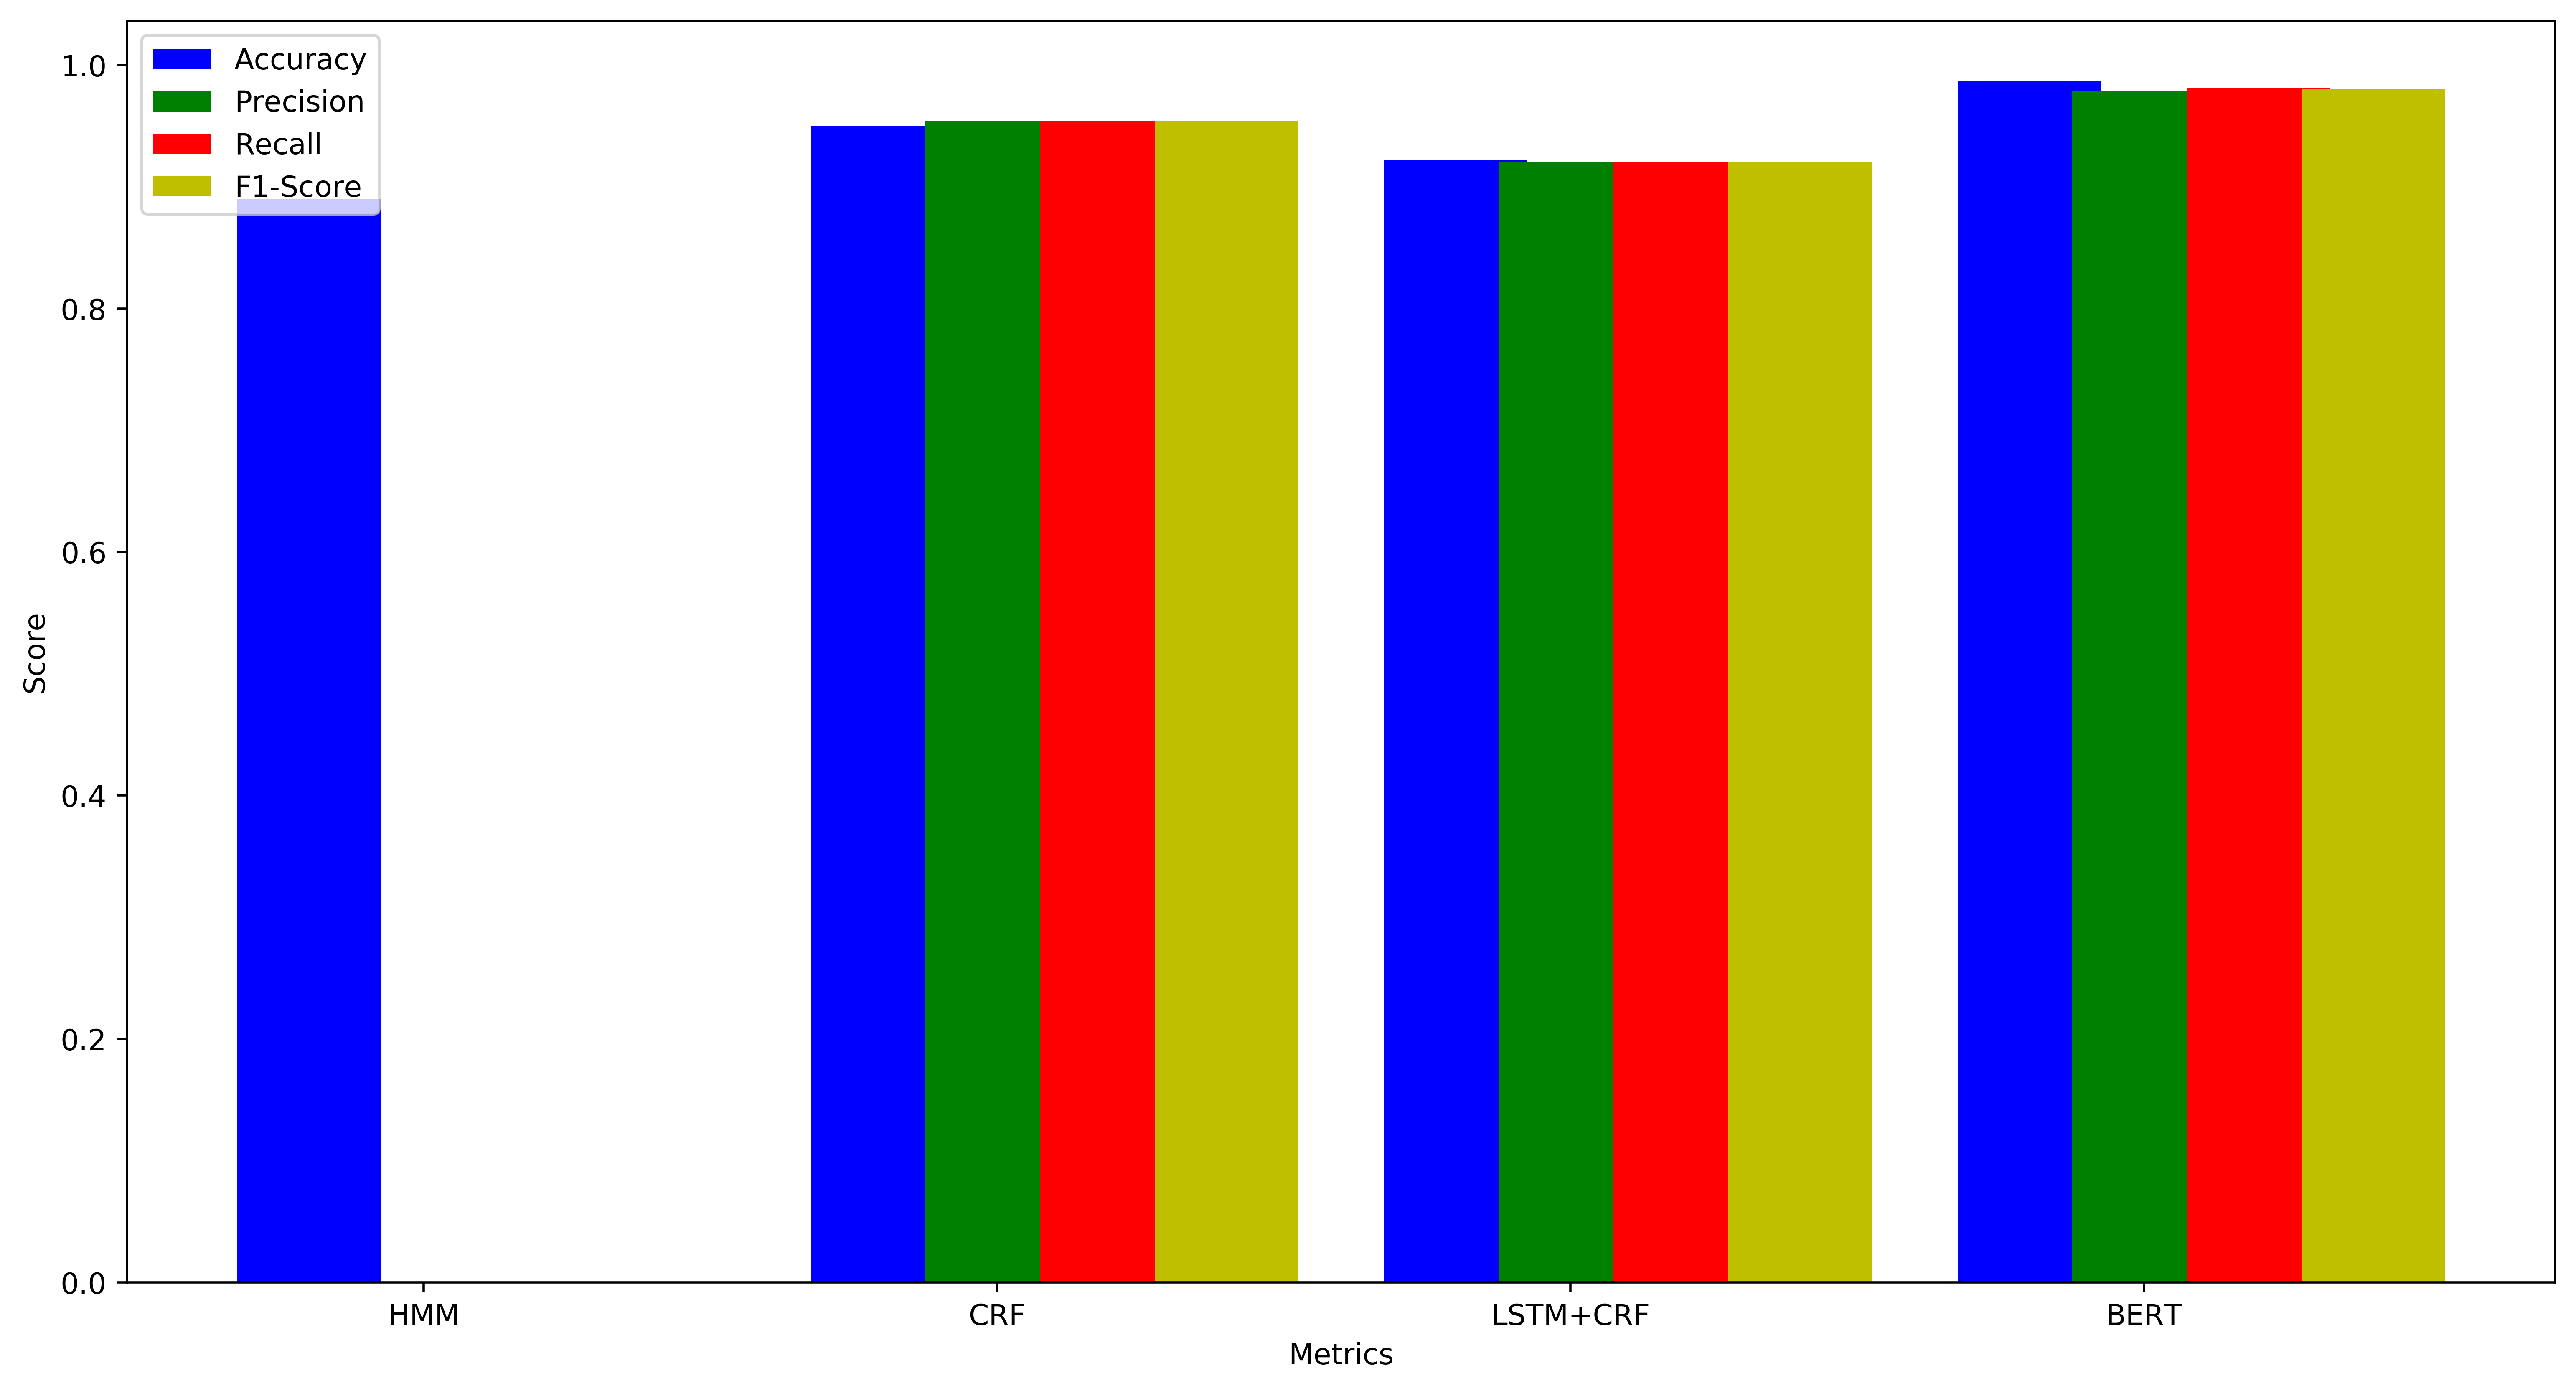

In [43]:
X = np.arange(4)

names = ["HMM", "CRF", "LSTM+CRF", "BERT"]

plt.bar(x, graph[0], color = 'b', width = 0.25, label="Accuracy")
plt.bar(x + width, graph[1], color = 'g', width = 0.25, label="Precision", tick_label=names)
plt.bar(x + 2*width, graph[2], color = 'r', width = 0.25, label="Recall")
plt.bar(x + 3*width, graph[3], color = 'y', width = 0.25, label="F1-Score")
plt.xticks()
plt.legend(loc="upper left")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.figsize'] = (15.0, 8.0)

plt.show()

#### 3.2 ScienceEXAM

In [44]:
base_line_acc = 0.794313

crf_acc = 0.8425619717911755
crf_precision = 0.8397306778799688
crf_recall = 0.8425619717911755
crf_f1 = 0.8361435928375092


lstmcrf_acc = 0.810792
lstmcrf_precision = 0.83
lstmcrf_recall = 0.81
lstmcrf_f1 = 0.81

bert_acc = 0.7579354984595381
bert_precision = 0.7311242245422908
bert_recall = 0.7104688287682742
bert_f1 = 0.7530166080413198

In [45]:
acc_g = [base_line_acc, crf_acc, lstmcrf_acc, bert_acc]
precision_g = [0, crf_precision, lstmcrf_precision, bert_precision]
recall_g = [0, crf_recall, lstmcrf_recall, bert_recall]
f1_g = [0, crf_f1, lstmcrf_f1, bert_f1]

graph = [acc_g, precision_g, recall_g, f1_g]

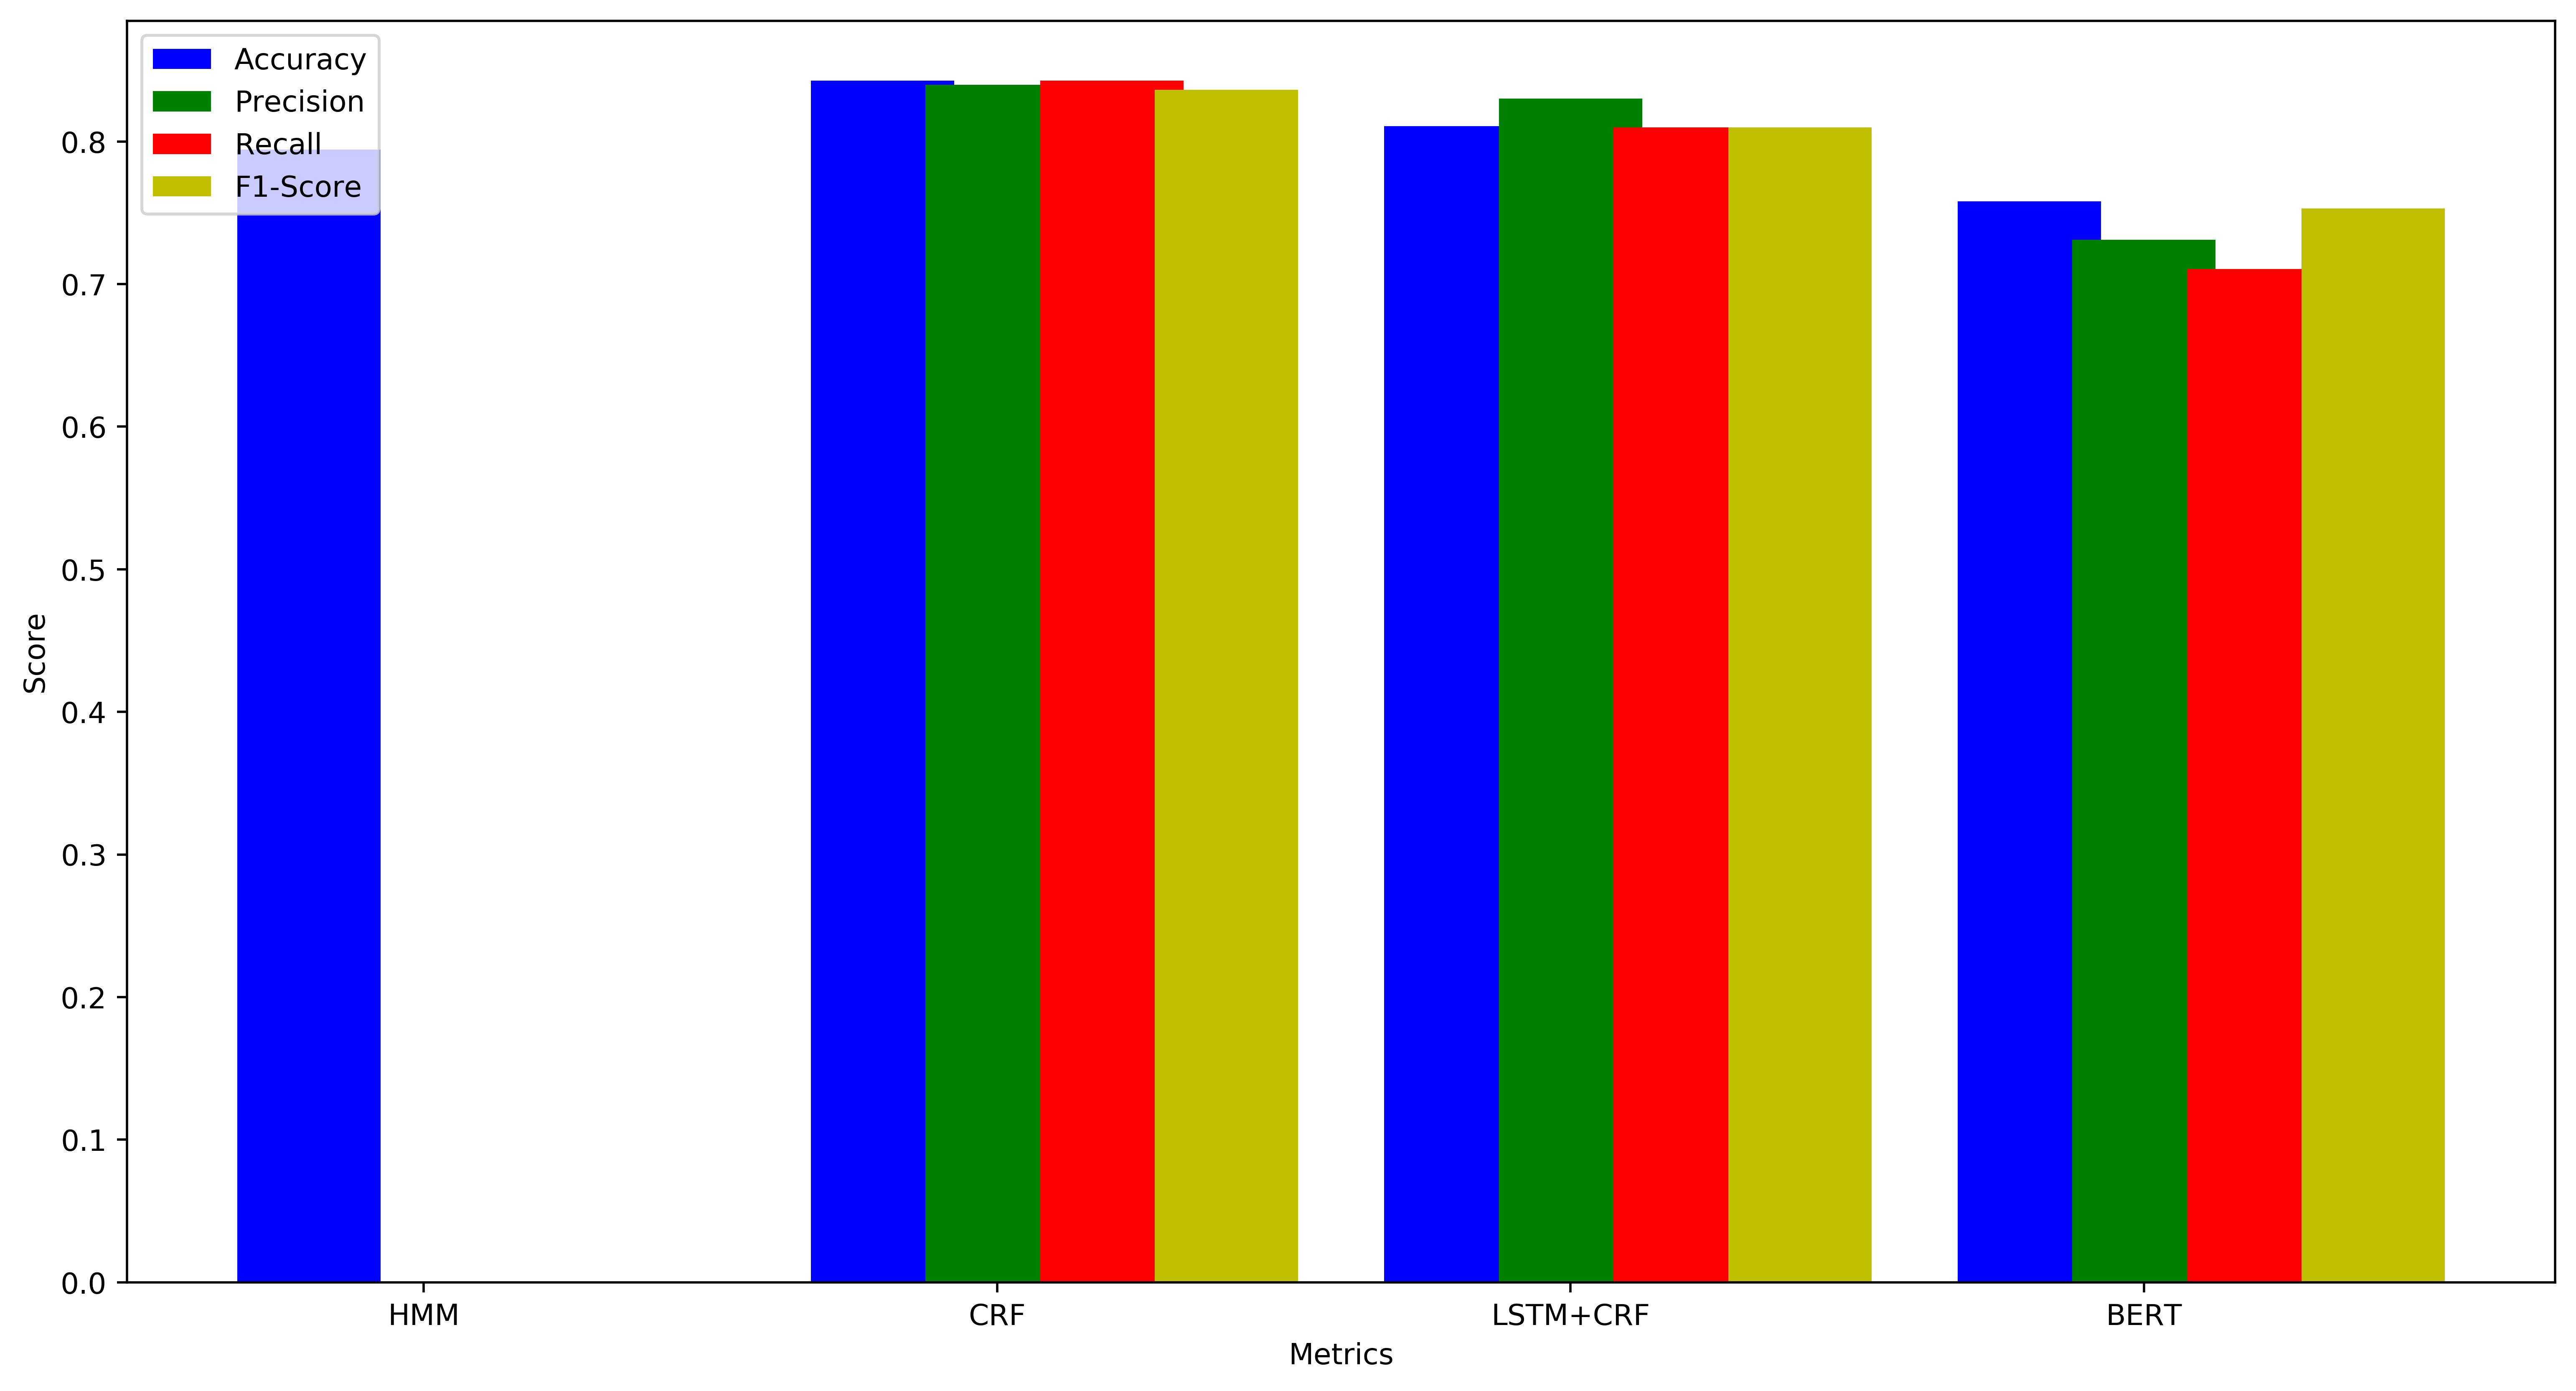

In [46]:
X = np.arange(4)

names = ["HMM", "CRF", "LSTM+CRF", "BERT"]

plt.bar(x, graph[0], color = 'b', width = 0.25, label="Accuracy")
plt.bar(x + width, graph[1], color = 'g', width = 0.25, label="Precision", tick_label=names)
plt.bar(x + 2*width, graph[2], color = 'r', width = 0.25, label="Recall")
plt.bar(x + 3*width, graph[3], color = 'y', width = 0.25, label="F1-Score")
plt.xticks()
plt.legend(loc="upper left")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.figsize'] = (15.0, 8.0)

plt.show()